In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\traitlets\con

In [2]:
# LOAD EIGENVALUES
PF_SIZE = 500



base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")

fixed_shrk_name = 'cov2Para'
opt_shrk_name = 'cov2Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_cov2Para_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\cov2Para_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)


qis_evs = pd.read_csv(fr"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues\qis_evs_df_p{PF_SIZE}.csv", index_col=0)
sample_evs = pd.read_csv(fr"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\transformed_qis_eigenvalues\sample_evs_df_p{PF_SIZE}.csv", index_col=0)

In [15]:
top10_quot = qis_evs.iloc[:, -10:].mean(axis=1) / sample_evs.iloc[:, -10:].mean(axis=1)
quot2 = top10_quot = qis_evs.iloc[:, -50:-10].mean(axis=1) / sample_evs.iloc[:, -50:-10].mean(axis=1)

In [13]:
qis_evs.iloc[:, -10:].mean(axis=1)

0        0.007976
1        0.008024
2        0.008029
3        0.008013
4        0.008044
           ...   
10348    0.010525
10349    0.010593
10350    0.010434
10351    0.010302
10352    0.010517
Length: 10353, dtype: float64

In [4]:
intensity_of_intensity_list = np.arange(0.5, 2.01, 0.05).round(2)
ioi_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\intensity_of_intensity_data"
all_res = pd.read_csv(ioi_path + f"\\all_res_p{PF_SIZE}_v2.csv", index_col=0)
all_rawres = pd.read_csv(ioi_path + f"\\all_rawres_p{PF_SIZE}_v2.csv", index_col=0)

In [5]:
allres_min_idxes_full = all_res.idxmin(axis=1)[: -21].values
allres_min_idxes_full = np.insert(allres_min_idxes_full, 0, np.repeat(["1.0"], 21))

# for sanity check: BIASED version should generally be better than
# non biased version as it is literally the minimum over the future 21 days
# so using it as a signal should outperform
allres_min_idxes_BIASED = all_res.idxmin(axis=1).values
allres_min_idxes_BIASED = allres_min_idxes_BIASED


# get all the validation indices
len_train = 5040
end_date = fixed_shrk_data.shape[0]
# temp here
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
reb_date_1 = permnos.index[0]
add_idx = np.where(rets_full.index == reb_date_1)[0][0]

In [6]:
all_factors = intensity_of_intensity_list
Y = allres_min_idxes_BIASED.astype(float)
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, allres_min_idxes_BIASED])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))



In [7]:
opt_v4 = np.copy(opt_v3)
opt_v4 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))[:-21]

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values

#### Define some helpers needed for model training

In [8]:
def eval_model_outputs(res, intensity_of_intensity_list, show_fig=True):
    res = [len(intensity_of_intensity_list)-1 if r > len(intensity_of_intensity_list) else r for r in res]
    res = [0 if r < 0 else r for r in res]
    res = re_hf.map_preds_to_factors(res, all_factors)
    Y_eval = all_rawres
    Y_eval.columns = Y_eval.columns.astype(str)
    res_evaluated2 = re_hf.evaluate_all_factor_preds(res, Y_eval, len_train)
    datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
    res_df = pd.DataFrame(np.array(res, dtype=float), index=datetime_index[5040:], columns=[""])
    
    fig = px.line(res_df, height=500, width=1000).update_layout(
        xaxis_title="Year", yaxis_title="Intensity of Intensity")
    
    print("Result:", res_evaluated2)
    if show_fig:
        fig.show()

    return fig

### Get Data and train model

In [10]:
top10_quot

array([[0.52940931, 0.5313873 , 0.53643931, ..., 0.70647229, 0.71789956,
        0.73588987],
       [0.5349153 , 0.53229936, 0.53554075, ..., 0.70430713, 0.70971944,
        0.73620545],
       [0.53665333, 0.5377583 , 0.53932774, ..., 0.70886881, 0.72281609,
        0.73615553],
       ...,
       [0.82372016, 0.81919674, 0.80846852, ..., 0.66620071, 0.65100356,
        0.66277839],
       [0.80814074, 0.80405901, 0.80534536, ..., 0.67728502, 0.68210875,
        0.66787158],
       [0.80019634, 0.7921385 , 0.79775163, ..., 0.65309987, 0.65751674,
        0.64130254]])

In [16]:
params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, top10_quot.values*100, quot2.values*100]  
}

X = re_hf.load_additional_train_data(**params)

In [17]:
%%capture
res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040)


In [18]:
fig = eval_model_outputs(res, intensity_of_intensity_list, show_fig=True)

Result: (np.float64(9.368), np.float64(10.366))


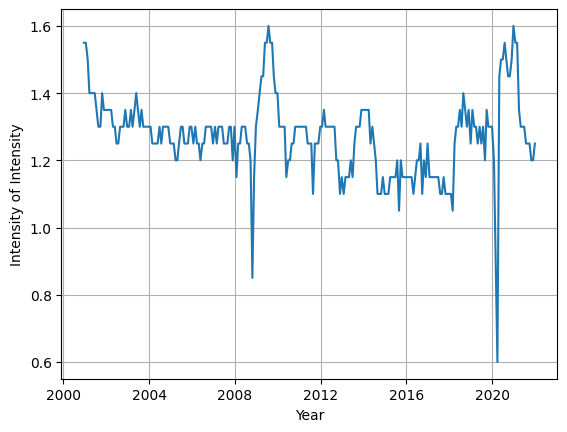

In [201]:
res2 = re_hf.map_preds_to_factors(res, all_factors)
Y_eval = all_rawres
Y_eval.columns = Y_eval.columns.astype(str)
res_evaluated2 = re_hf.evaluate_all_factor_preds(res2, Y_eval, len_train)
datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
res_df = pd.DataFrame(np.array(res2, dtype=float), index=datetime_index[5040:], columns=["Intensity"])
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df["Intensity"])

ax.set(xlabel='Year', ylabel='Intensity of Intensity')
ax.grid()

#### Cross-Validation

In [19]:
from sklearn.linear_model import ElasticNet
def general_single_output_ElasticNet_Lagged_CrossValidation(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={}):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = ElasticNet(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = ElasticNet(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            preds = np.round(preds, 0)
            model_predictions.append(preds)


def eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train):
    res = [len(intensity_of_intensity_list)-1 if r > len(intensity_of_intensity_list) else r for r in res]
    res = [0 if r < 0 else r for r in res]
    res = re_hf.map_preds_to_factors(res, all_factors)

    Y_eval = all_rawres.iloc[len_cv_train:len_train]

    returns = np.diag(Y_eval.loc[:, res])
    returns_sd = returns.std() * np.sqrt(252) * 100
    returns_means = returns.mean() * 252 * 100

    return returns_means, returns_sd

In [20]:
len_cv_train = int(len_train*0.8) 

train_x_cv = X[:len_cv_train]
train_y_cv = Y[:len_cv_train]

val_x = X[len_cv_train:len_train]
val_y = Y[len_cv_train:len_train]

In [21]:
%%capture

from sklearn.model_selection import ParameterGrid
model_params_grid = {
    "alpha": [0.5, 1.0, 1.5, 2.0],
    "l1_ratio": [0.25, 0.5, 0.75],
    "max_iter": [500, 1000, 1500, 2000],
    "tol": [1e-3, 1e-4, 1e-5]
}
model_params_grid = list(ParameterGrid(model_params_grid))

sds = []
for p in model_params_grid:
    res = general_single_output_ElasticNet_Lagged_CrossValidation(X=X[:len_train], Y=Y[:len_train], len_train=len_cv_train, model_params=p)
    AV, SD = eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train)
    sds.append(SD.round(3))

#### Evaluate best model on OOS data

In [127]:
np.argmin(sds)
p_best = model_params_grid[np.argmin(sds)]
res = general_single_output_ElasticNet_Lagged_CrossValidation(X=X, Y=Y, len_train=len_train, model_params=p_best)
#fig = eval_model_outputs(res, intensity_of_intensity_list, show_fig=True)

### Matplotlib  plots

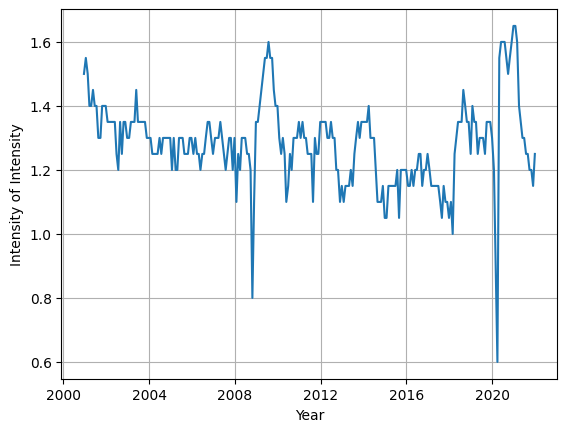

In [128]:
res2 = re_hf.map_preds_to_factors(res, all_factors)
Y_eval = all_rawres
Y_eval.columns = Y_eval.columns.astype(str)
res_evaluated2 = re_hf.evaluate_all_factor_preds(res2, Y_eval, len_train)
datetime_index = pd.to_datetime(permnos.index, format="%Y%m%d")
res_df = pd.DataFrame(np.array(res2, dtype=float), index=datetime_index[5040:], columns=["Intensity"])
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df["Intensity"])

ax.set(xlabel='Year', ylabel='Intensity of Intensity')
ax.grid()

### Average ElasticNet and XGB

In [48]:
from xgboost import XGBRegressor
def general_single_output_XGB_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={} ):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = XGBRegressor(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = XGBRegressor(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            preds = int(np.round(preds, 0))
            
            if i % 50 == 0:
                print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)

In [46]:
xgb_params={
    'n_estimators': 2000,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5
}
res_xgb = general_single_output_XGB_Lagged(X=X, Y=Y, len_train=5040, model_params=xgb_params)

C:\Users\dkostovic\AppData\Local\Temp\3\ipykernel_42728\2213940639.py:31: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



fitted model in iteration 0 out of 253
fitted model in iteration 1 out of 253
fitted model in iteration 2 out of 253
fitted model in iteration 3 out of 253
fitted model in iteration 4 out of 253
fitted model in iteration 5 out of 253
fitted model in iteration 6 out of 253
fitted model in iteration 7 out of 253
fitted model in iteration 8 out of 253
fitted model in iteration 9 out of 253
fitted model in iteration 10 out of 253
fitted model in iteration 11 out of 253
fitted model in iteration 12 out of 253
fitted model in iteration 13 out of 253
fitted model in iteration 14 out of 253
fitted model in iteration 15 out of 253
fitted model in iteration 16 out of 253
fitted model in iteration 17 out of 253
fitted model in iteration 18 out of 253
fitted model in iteration 19 out of 253
fitted model in iteration 20 out of 253
fitted model in iteration 21 out of 253
fitted model in iteration 22 out of 253
fitted model in iteration 23 out of 253
fitted model in iteration 24 out of 253
fitted mod

### Y as rolling mean

In [117]:
all_factors = intensity_of_intensity_list
Y = allres_min_idxes_BIASED.astype(float)
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, allres_min_idxes_BIASED])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))



opt_v4 = np.copy(opt_v3)
opt_v4 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))[:-21]

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
Y = pd.Series(Y).rolling(window=ROLL_WINDOW, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=2, min_periods=1).mean().astype(np.int64).values

params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2]  
}

X = re_hf.load_additional_train_data(**params)

In [119]:
res_xgb = general_single_output_XGB_Lagged(X=X, Y=Y, len_train=5040)
fig = eval_model_outputs(res_xgb, intensity_of_intensity_list, show_fig=True)

C:\Users\dkostovic\AppData\Local\Temp\3\ipykernel_42728\2030131491.py:31: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



fitted model in iteration 0 out of 253


KeyError: np.int64(31)

In [118]:
res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040)
fig = eval_model_outputs(res, intensity_of_intensity_list, show_fig=True)

Result: (np.float64(9.399), np.float64(10.363))


In [107]:
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
tmp = opt_values[5040:]

tmp

array([28, 26, 26, ..., 23, 26, 23])

In [112]:
opt_values = allres_min_idxes_BIASED.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(1.0, 21))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
tmp = opt_values[5040:]

for i in list(range(1,252,2)):
    ROLL_TMP_WINDOW = i
    tmp = pd.Series(tmp).rolling(window=ROLL_TMP_WINDOW, min_periods=1).mean().round(0)
    x = ( np.diag(all_rawres.iloc[5040:].iloc[:, tmp]) ).std() * np.sqrt(252) * 100
    print(x)

10.408670013357277
10.394729100942419
10.420158628907204
10.437121984225438
10.445951636503331
10.43550067636987
10.424984081223036
10.409161721986852
10.429172654584924
10.438305238136433
10.439563006416591
10.434932823813229
10.434941297322322
10.442614832751868
10.449080054700566
10.455255906728018
10.447220807638784
10.429132188530852
10.417387295027263
10.413709493048612
10.40770089824406
10.40433853013296
10.397378033445767
10.386114789684765
10.378807664844881
10.382396559843484
10.3938107196794
10.408646795568036
10.423902910695315
10.436409839345826
10.446289101374479
10.44523516243487
10.446005246512541
10.446040272028165
10.448278654316809
10.441769096913019
10.439407292127783
10.43467834691784
10.423915087474903
10.426897855240377
10.427249679056558
10.426556567522837
10.426199735183804
10.430898402377247
10.431097642195738
10.43408203248976
10.437858410119812
10.444874110793831
10.44525025540799
10.444634484431877
10.448652214105678
10.458659765675481
10.458337238031548
10

### Create results df for fixed intensity

In [154]:
pf_sds = {}
pf_means = {}
for PF_SIZE in [30, 50, 100, 225, 500]:
    ioi_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\intensity_of_intensity_data"
    #all_res = pd.read_csv(ioi_path + f"\\all_res_p{PF_SIZE}_v2.csv", index_col=0)
    all_rawres = pd.read_csv(ioi_path + f"\\all_rawres_p{PF_SIZE}_v2.csv", index_col=0)

    pf_sds[PF_SIZE] = (all_rawres.iloc[5040:, :].std() * np.sqrt(252) * 100).values.round(2)
    pf_means[PF_SIZE] = (all_rawres.iloc[5040:, :].mean() * 252 * 100).values.round(2)

pf_means_df = pd.DataFrame(pf_means).T
pf_means_df.columns = all_rawres.columns

pf_sds_df = pd.DataFrame(pf_sds).T
pf_sds_df.columns = all_rawres.columns

out_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\NonLinear_Shrinkage\results"

pf_means_df.to_csv(f"{out_path}/AV_fixed_intensity.csv")
pf_sds_df.to_csv(f"{out_path}/SD_fixed_intensity.csv")